# Optimizing hyperparameters for DL models on the IDS2017 dataset

In this notebook, different DL models are used on the IDS2017 with hyperparameter optimization to test the performance. Deep neural networks, autoencoders, convolutional networks and RNNs are tested on the dataset.

In [1]:
from utils_ids2017 import load_ids2017, feature_selection
from notebook_utils import plot_confusion_matrix, metrics_report, calculate_metrics_by_label, test_metrics_DL, plot_overall_accuracy
from notebook_utils import test_metrics_AE
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

attack_labels = {
    0: 'BENIGN',
    7: 'FTP-Patator',
    11: 'SSH-Patator',
    6: 'DoS slowloris',
    5: 'DoS Slowhttptest',
    4: 'DoS Hulk',
    3: 'DoS GoldenEye',
    8: 'Heartbleed',
    12: 'Web Attack - Brute Force',
    14: 'Web Attack - XSS',
    13: 'Web Attack - Sql Injection',
    9: 'Infiltration',
    1: 'Bot',
    10: 'PortScan',
    2: 'DDoS'
}

## Load Dataset

In [2]:
df = load_ids2017()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 96 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   destination_port             int64   
 1   protocol                     int64   
 2   flow_duration                int64   
 3   total_fwd_packets            int64   
 4   total_backward_packets       int64   
 5   total_length_of_fwd_packets  float64 
 6   total_length_of_bwd_packets  float64 
 7   fwd_packet_length_max        float64 
 8   fwd_packet_length_min        float64 
 9   fwd_packet_length_mean       float64 
 10  fwd_packet_length_std        float64 
 11  bwd_packet_length_max        float64 
 12  bwd_packet_length_min        float64 
 13  bwd_packet_length_mean       float64 
 14  bwd_packet_length_std        float64 
 15  flow_bytes_s                 float64 
 16  flow_packets_s               float64 
 17  flow_iat_mean                float64 
 18  flow_iat_std          

In [3]:
X = df.iloc[:, 0:79]
Y = df.iloc[:, 79:]
X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 2827876 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   protocol                     int64  
 2   flow_duration                int64  
 3   total_fwd_packets            int64  
 4   total_backward_packets       int64  
 5   total_length_of_fwd_packets  float64
 6   total_length_of_bwd_packets  float64
 7   fwd_packet_length_max        float64
 8   fwd_packet_length_min        float64
 9   fwd_packet_length_mean       float64
 10  fwd_packet_length_std        float64
 11  bwd_packet_length_max        float64
 12  bwd_packet_length_min        float64
 13  bwd_packet_length_mean       float64
 14  bwd_packet_length_std        float64
 15  flow_bytes_s                 float64
 16  flow_packets_s               float64
 17  flow_iat_mean                float64
 18  flow_iat_std                 float64
 19  flow_

## Feature Selection

In [4]:
X = feature_selection(X, Y)

                        Feature  Information Gain
1                 flow_duration          0.227972
10               flow_packets_s          0.217930
3   total_length_of_fwd_packets          0.211401
11                flow_iat_mean          0.208215
9                  flow_bytes_s          0.203891
23                bwd_packets_s          0.198856
31       init_win_bytes_forward          0.188452
4         fwd_packet_length_max          0.187859
6        fwd_packet_length_mean          0.182248
12                 flow_iat_std          0.175964
7         bwd_packet_length_max          0.166356
32      init_win_bytes_backward          0.151696
18                  bwd_iat_max          0.150815
15                bwd_iat_total          0.149683
16                 bwd_iat_mean          0.141842
21            fwd_header_length          0.137165
24            min_packet_length          0.114500
5         fwd_packet_length_min          0.112653
13                 flow_iat_min          0.106056


## Split Dataset

The dataset is split into a training set and a testing set with a ratio of 0.8/0.2. The dataset is stratified according to the label to have an equal representation of all classes in the 2 subsets.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y.label_code)

In [6]:
Y_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
DoS GoldenEye                    8234
FTP-Patator                      6348
SSH-Patator                      4717
DoS slowloris                    4637
DoS Slowhttptest                 4399
Bot                              1565
Web Attack - Brute Force         1206
Web Attack - XSS                  522
Infiltration                       29
Web Attack - Sql Injection         17
Heartbleed                          9
Name: count, dtype: int64

In [7]:
Y_test.label.value_counts()

label
BENIGN                        454265
DoS Hulk                       46025
PortScan                       31761
DDoS                           25605
DoS GoldenEye                   2059
FTP-Patator                     1587
SSH-Patator                     1180
DoS slowloris                   1159
DoS Slowhttptest                1100
Bot                              391
Web Attack - Brute Force         301
Web Attack - XSS                 130
Infiltration                       7
Web Attack - Sql Injection         4
Heartbleed                         2
Name: count, dtype: int64

Statistics about the data

In [8]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.8032
is_attack
0    1817055
1     445245
Name: count, dtype: int64


## SMOTE Resampling

In [9]:
from imblearn.over_sampling import SMOTE

def resample_dataset(X, Y, min_samples, attack_labels):
    Y = Y.drop(columns=['label'])
    combined = pd.concat([X, Y], axis=1)
    counts = Y['label_code'].value_counts()
    samples_number = {i: max(counts[i], min_samples) for i in np.unique(Y['label_code'])}
    combined_array = combined.values
    y_array = Y['label_code'].values
    resampler = SMOTE(random_state=42, sampling_strategy=samples_number)
    resampled_array, y_resampled = resampler.fit_resample(combined_array, y_array)
    X_resampled = resampled_array[:, :-Y.shape[1]]
    Y_resampled = resampled_array[:, -Y.shape[1]:]
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    Y_resampled_df = pd.DataFrame(Y_resampled, columns=Y.columns)
    Y_resampled_df['label'] = Y_resampled_df['label_code'].map(attack_labels)
    Y_resampled_df['label'] = Y_resampled_df['label'].astype('category')
    return X_resampled_df, Y_resampled_df

X_smote_train, Y_smote_train = resample_dataset(X_train, Y_train, 100000, attack_labels)


In [10]:
Y_smote_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [11]:
from sklearn.preprocessing import StandardScaler

scaler_smote = StandardScaler()
scaler_smote.fit(X_smote_train)

StandardScaler()

In [12]:
# Save the model
def save_model(model, model_name):
    # Create directory if it does not exist
    model_dir = os.path.join("models", "DL_models_optimized")
    os.makedirs(model_dir, exist_ok=True)
    # Save the model
    model.save(os.path.join(model_dir, f"{model_name}.keras"))

metrics = {}

## Optimized DNN

Reloading Tuner from optimization\DNN_combined_fixed_dropout\tuner0.json
The optimal hyperparameters are: {'num_layers': 4, 'dropout': 0.1, 'learning_rate': 0.0001, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 77s 911us/step - accuracy: 0.9208 - loss: 0.1728 - val_accuracy: 0.2165 - val_loss: 4.3306
Epoch 2/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 76s 910us/step - accuracy: 0.9580 - loss: 0.0959 - val_accuracy: 0.2539 - val_loss: 3.2616
Epoch 3/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 78s 930us/step - accuracy: 0.9613 - loss: 0.0870 - val_accuracy: 0.2301 - val_loss: 2.8311
Epoch 4/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 75s 899us/step - accuracy: 0.9630 - loss: 0.0828 - val_accuracy: 0.2478 - val_loss: 2.3396
Epoch 5/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 78s 934us/step - accuracy: 0.9648 - loss: 0.0798 - val_accuracy: 0.2480 - val_loss: 2.6469
Epoch 6/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 76s 916us/step - accuracy: 0.965

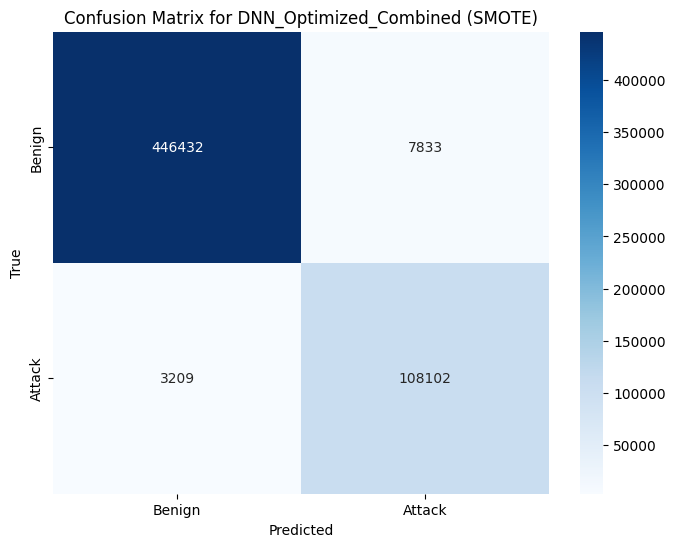

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.982757  SMOTE
1                     DoS Hulk  0.987550  SMOTE
2                DoS GoldenEye  0.994658  SMOTE
3                         DDoS  0.987424  SMOTE
4                     PortScan  0.948900  SMOTE
5                DoS slowloris  0.996549  SMOTE
6                  FTP-Patator  0.996219  SMOTE
7     Web Attack - Brute Force  0.096346  SMOTE
8                  SSH-Patator  0.794915  SMOTE
9             DoS Slowhttptest  0.994545  SMOTE
10                         Bot  0.961637  SMOTE
11            Web Attack - XSS  0.023077  SMOTE
12                Infiltration  0.142857  SMOTE
13  Web Attack - Sql Injection  0.500000  SMOTE
14                  Heartbleed  1.000000  SMOTE


In [13]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Define the combined model builder function
def build_combined_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_smote_train.shape[1],)))

    # Choose the number of layers (either 3 or 4)
    num_layers = hp.Choice('num_layers', values=[3, 4])
    
    # Same dropout rate for all layers
    dropout_rate = hp.Choice('dropout', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

    if num_layers == 3:
        # Fixed units for 3 layers: 128, 64, 32
        units_per_layer = [128, 64, 32]
    else:
        # Fixed units for 4 layers: 256, 128, 64, 32
        units_per_layer = [256, 128, 64, 32]
    
    for i in range(num_layers):
        model.add(Dense(units=units_per_layer[i], activation='relu'))
        model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Use Adam optimizer with different learning rates
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner for the combined model
tuner_combined = kt.Hyperband(build_combined_model,
                              objective='accuracy',
                              max_epochs=20,
                              factor=3,
                              directory='optimization',
                              project_name='DNN_combined_fixed_dropout')

# Early stopping callback
stop_early = EarlyStopping(monitor='accuracy', patience=5)

# Perform hyperparameter search for the combined model
tuner_combined.search(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack, 
                      epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_combined = tuner_combined.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal hyperparameters are: {best_hps_combined.values}")

# Build and train the model with the optimal hyperparameters
model_combined = tuner_combined.hypermodel.build(best_hps_combined)
history_combined = model_combined.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack, 
                                      epochs=50, validation_split=0.2, callbacks=[stop_early])

# Evaluate and save the model
metrics["DNN_Optimized_Combined"] = test_metrics_DL("DNN_Optimized_Combined", model_combined, scaler_smote, X_test, Y_test, reshape=False)
save_model(model_combined, "DNN_SMOTE_Optimized_Combined")

## Optimized CNN


Reloading Tuner from optimization\cnn_tuning_fixed_units_filters\tuner0.json
The optimal hyperparameters are: {'kernel_size': 3, 'dropout': 0.0, 'learning_rate': 0.001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}
Epoch 1/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 87s 1ms/step - accuracy: 0.9361 - loss: 0.1405 - val_accuracy: 0.2495 - val_loss: 3.6297
Epoch 2/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 84s 1ms/step - accuracy: 0.9607 - loss: 0.0888 - val_accuracy: 0.2611 - val_loss: 3.5825
Epoch 3/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 83s 993us/step - accuracy: 0.9640 - loss: 0.0812 - val_accuracy: 0.4005 - val_loss: 1.9908
Epoch 4/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 83s 995us/step - accuracy: 0.9657 - loss: 0.0778 - val_accuracy: 0.2864 - val_loss: 3.2660
Epoch 5/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 83s 998us/step - accuracy: 0.9666 - loss: 0.0758 - val_accuracy: 0.4373 - val_loss: 1.9226
Epoch 6/50
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 83s 1

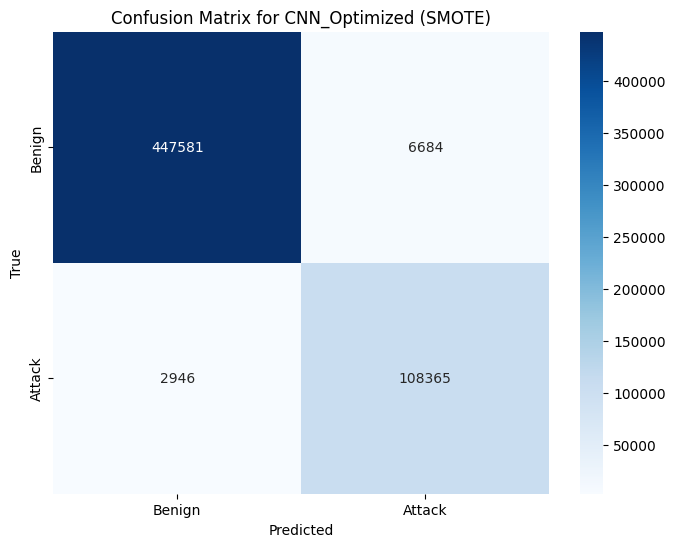

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.985286  SMOTE
1                     DoS Hulk  0.981336  SMOTE
2                DoS GoldenEye  0.994172  SMOTE
3                         DDoS  0.998321  SMOTE
4                     PortScan  0.951198  SMOTE
5                DoS slowloris  0.996549  SMOTE
6                  FTP-Patator  0.996849  SMOTE
7     Web Attack - Brute Force  0.132890  SMOTE
8                  SSH-Patator  0.946610  SMOTE
9             DoS Slowhttptest  0.995455  SMOTE
10                         Bot  0.976982  SMOTE
11            Web Attack - XSS  0.030769  SMOTE
12                Infiltration  0.142857  SMOTE
13  Web Attack - Sql Injection  0.500000  SMOTE
14                  Heartbleed  0.500000  SMOTE


In [14]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Input, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Ensure TensorFlow compatibility
tf.compat.v1.reset_default_graph()

# Define the model builder function for CNN with fixed units and filters, and reduced dropout range
def build_cnn_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_smote_train.shape[1], 1)))
    
    # Fixed number of filters in the Conv1D layer
    model.add(Conv1D(filters=64,
                     kernel_size=hp.Int('kernel_size', min_value=2, max_value=5, step=1),
                     activation='relu'))
    
    # Flatten layer
    model.add(Flatten())
    
    # Fully connected layer with fixed units
    model.add(Dense(units=64, activation='relu'))
    
    # Dropout layer with reduced range
    model.add(Dropout(rate=hp.Choice('dropout', values=[0.0, 0.2, 0.4])))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Adam optimizer with different learning rates
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.Hyperband(build_cnn_model,
                     objective='accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='optimization',
                     project_name='cnn_tuning_fixed_units_filters')

# Early stopping callback
stop_early = EarlyStopping(monitor='accuracy', patience=5)

# Perform hyperparameter search
tuner.search(scaler_smote.transform(X_smote_train).reshape(-1, X_smote_train.shape[1], 1), 
             Y_smote_train.is_attack, 
             epochs=50, 
             validation_split=0.2, 
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal hyperparameters are: {best_hps.values}")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(scaler_smote.transform(X_smote_train).reshape(-1, X_smote_train.shape[1], 1), 
                    Y_smote_train.is_attack, 
                    epochs=50, 
                    validation_split=0.2, 
                    callbacks=[stop_early])

# Evaluate and save the model
metrics["CNN_Optimized"] = test_metrics_DL("CNN_Optimized", model, scaler_smote, X_test, Y_test, reshape=False)
save_model(model, "CNN_SMOTE_Optimized")

## Optimized RNN

In [ ]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Define the updated balanced model builder function for RNN
def build_updated_rnn_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_smote_train.shape[1], 1)))

    # Tune the number of units in the LSTM layer
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=128, step=32)))
    
    # Fully connected layer
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=64, step=32), activation='relu'))

    # Dropout layer with a range from 0 to 0.5
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.4, step=0.2)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Adam optimizer with the original set of learning rates
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.Hyperband(build_updated_rnn_model,
                     objective='accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='optimization',
                     project_name='updated_rnn_tuning')

# Early stopping callback
stop_early = EarlyStopping(monitor='accuracy', patience=5)

# Perform hyperparameter search
tuner.search(scaler_smote.transform(X_smote_train).reshape(-1, X_smote_train.shape[1], 1), 
             Y_smote_train.is_attack, 
             epochs=50, 
             validation_split=0.2, 
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal hyperparameters are: {best_hps.values}")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(scaler_smote.transform(X_smote_train).reshape(-1, X_smote_train.shape[1], 1), 
                    Y_smote_train.is_attack, 
                    epochs=50, 
                    validation_split=0.2, 
                    callbacks=[stop_early])

# Evaluate and save the model
metrics["RNN_Optimized"] = test_metrics_DL("RNN_Optimized", model, scaler_smote, X_test, Y_test, reshape=False)
save_model(model, "RNN_SMOTE_Optimized")


Trial 20 Complete [00h 56m 31s]
accuracy: 0.9700186848640442

Best accuracy So Far: 0.9796929359436035
Total elapsed time: 2d 10h 06m 32s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
96                |64                |units
64                |64                |dense_units
0.4               |0                 |dropout
0.001             |0.001             |learning_rate
7                 |7                 |tuner/epochs
0                 |3                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/7
40693/83266 ━━━━━━━━━━━━━━━━━━━━ 5:48 8ms/step - accuracy: 0.8961 - loss: 0.2109

## Autoencoder

In [ ]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Define the model builder function for Autoencoder
def build_autoencoder_model_with_threshold(hp):
    model = Sequential()
    model.add(Input(shape=(benign_data.shape[1],)))

    # Encoder
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dense(units=hp.Int('bottleneck', min_value=8, max_value=16, step=8), activation='relu'))
    
    # Decoder
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=32), activation='relu'))
    
    # Reconstruct the input
    model.add(Dense(benign_data.shape[1], activation='sigmoid'))

    # Compile the model
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize the tuner
tuner = kt.Hyperband(build_autoencoder_model_with_threshold,
                     objective=kt.Objective("val_loss", direction="min"),
                     max_epochs=20,
                     factor=3,
                     directory='optimization',
                     project_name='autoencoder_tuning_with_threshold')

# Early stopping callback
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search, including threshold tuning
tuner.search(scaler_AE.transform(benign_data), scaler_AE.transform(benign_data), 
             epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal hyperparameters are: {best_hps.values}")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(scaler_AE.transform(benign_data), scaler_AE.transform(benign_data), 
                    epochs=50, validation_split=0.2, callbacks=[stop_early])


In [ ]:
# Get reconstruction errors on the validation set
reconstructions = model.predict(scaler_AE.transform(benign_data))
reconstruction_errors = np.mean(np.square(scaler_AE.transform(benign_data) - reconstructions), axis=1)

# Tune threshold by trying different percentiles
best_threshold = None
best_accuracy = -1
percentiles = range(80, 100)

for percentile in percentiles:
    threshold = np.percentile(reconstruction_errors, percentile)
    metrics["AE_Optimized"], metrics_by_label = test_metrics_AE(
        "AE_Optimized", model, scaler_AE, X_test, Y_test, threshold=threshold)

    # Assuming you have some F1 score metric in your `metrics` dictionary
    if metrics["AE_Optimized"]["accuracy"] > best_accuracy:
        best_accuracy = metrics["AE_Optimized"]["accuracy"]
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold}, Best F1 Score: {best_f1_score}")

# Save the model
save_model(model, "AE_SMOTE_Optimized")